In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

## Цель данного анализа: разработать стратегию масштабирования команды колл-центра для увеличения общего количества контактов в месяц на 20%

### Задачи:
1. Проанализировать и количественно описать разницу в индивидуальной производительности (контакты в час) между сотрудниками разных категорий стажа.
2. Определить 'стоимость' потери одного опытного сотрудника в эквиваленте производительности новичков.
3. Рассчитать требуемую численность новой команды для выполнения плана.

# Раздел 1. Динамика численности сотрудников в течение года

Загружаем сотрудников КЦ и их часы работы из файла 'employees.csv'

In [2]:
# Файл с именами сотрудников и их часами работы в каждом месяце
employee = pd.read_csv('../data/employees.csv')

# Приведем типы данных к нужным
employee['period'] = pd.to_datetime(employee['period'], format = '%Y-%m-%d')
employee['hire_date'] = pd.to_datetime(employee['hire_date'], format = '%Y-%m-%d')
employee['dismissal_date'] = pd.to_datetime(employee['dismissal_date'], format = '%Y-%m-%d')
employee['hours'] = employee['hours'].astype('int')
employee['name'] = employee['name'].str.strip()

In [3]:
# Задаем имя папки для сохранения изображений
IMAGE_DIR = '../images'

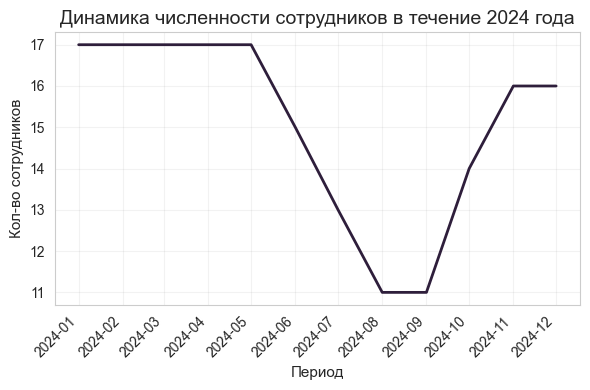

In [4]:
# График динамики численности сотрудников
# Группируем по периоду, считая кол-во сотрудников
employee_group = employee.groupby('period')['name'].count().reset_index()
plt.figure(figsize=(6, 4))  

# Построение графика
palette = sns.color_palette('mako')
sns.lineplot(data=employee_group, 
             x='period', y='name', 
             color=palette[0],
             linewidth=2)
# Настройки графика
sns.cubehelix_palette(as_cmap=True)
plt.title('Динамика численности сотрудников в течение 2024 года', fontsize=14)
plt.xlabel('Период', fontsize=11)
plt.ylabel('Кол-во сотрудников', fontsize=11)
plt.xticks(ticks=employee_group['period'], 
           labels=employee_group['period'].dt.strftime('%Y-%m'),
           rotation=45, ha='right')  
plt.grid(True, color='gray', alpha=0.1)
plt.tight_layout()  

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Динамика численности сотрудников в течение 2024 года.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

Ключевые изменения в численности персонала произошли во второй половине года. С наступлением лета начался период увольнения сотрудников, который продлился до осени. С октября отдел колл-центра начал восполнять кадровый состав. 

Несмотря на существенные колебания в середине года, итоговое изменение численности за год оказалось минимальным: с 17 сотрудников в начале года до 16 в конце.

## Структура штата по категориям стажа

Разделим на группы в зависимости от проработанного времени в компании
- 1 группа: сотрудник проработал меньше 3 месяцев (испытательный срок)
- 2 группа: 3-6 месяцев
- 3 группа: больше 6 месяцев

In [5]:
# Добавим столбец со стажем работы
def work_experience(df):
    df = df.copy()
    # Заполняем NaT в дате увольнения текущей датой
    df['end_date'] = df['dismissal_date'].fillna(pd.Timestamp(datetime.now().date()))
    # Разница в полных месяцах между месяцем принятия на работу и периодом
    df['work_experience_months'] = (
        (df['period'].dt.year - df['hire_date'].dt.year) * 12 +
        (df['period'].dt.month - df['hire_date'].dt.month)
    )
    return df[['name', 'period', 'hours', 'uuid', 
               'hire_date', 'dismissal_date', 'work_experience_months']]
employee = work_experience(employee)

# Добавим категорию стажа
def categorize_experience(work_experience_months):
    if work_experience_months < 4:  
        return 1
    elif (work_experience_months > 3) & (work_experience_months < 7):  
        return 2
    else:
        return 3  # опыт работы больше 6 месяцев

# Применяем функцию к столбцу 'work_experience_months' с помощью map()
employee['category_of_experience'] = employee['work_experience_months'].map(categorize_experience)

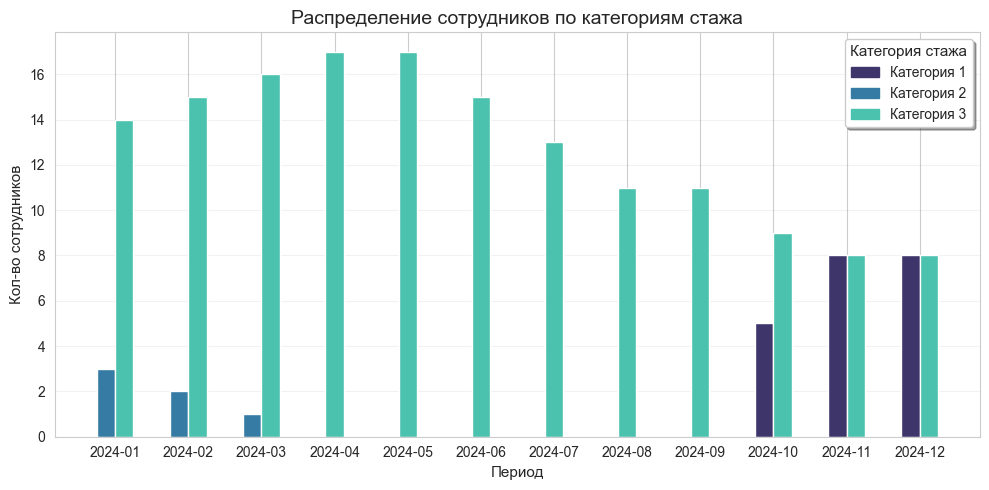

In [6]:
# Построим столбчатую диаграмму, показывающую распределение сотрудников по категориям стажа
# Группируем по периоду и категории стажа
category_group = (employee
                  .groupby(['period', 'category_of_experience'])['name'].count()
                  .reset_index())
category_group['period'] = category_group['period'].dt.strftime('%Y-%m')

periods = sorted(category_group['period'].unique())
categories = sorted(category_group['category_of_experience'].unique())
palette = sns.color_palette('mako', n_colors=len(categories))
color_map = {cat: color for cat, color in zip(categories, palette)}

fig, ax = plt.subplots(figsize=(10, 5))
# Задаем фиксированную ширину для КАЖДОГО отдельного столбца
fixed_bar_width = 0.25 

x_positions = np.arange(len(periods))

# Отрисовка
for i, period in enumerate(periods):
    period_data = category_group[category_group['period'] == period].sort_values('category_of_experience')
    
    n_bars = len(period_data)
    group_width = n_bars * fixed_bar_width
    
    # Стартовая позиция для первого столбца в группе (чтобы вся группа была по центру)
    start_pos = x_positions[i] - group_width / 2
    
    # Вычисляем позиции для центров каждого из столбцов в группе
    bar_positions = [start_pos + j * fixed_bar_width + fixed_bar_width / 2 for j in range(n_bars)]

    # Рисуем столбцы, используя ФИКСИРОВАННУЮ ширину
    ax.bar(bar_positions, 
           period_data['name'], 
           width=fixed_bar_width,  # Используем константу
           color=[color_map[cat] for cat in period_data['category_of_experience']])

# Настройка графика
ax.set_title('Распределение сотрудников по категориям стажа', fontsize=14)
ax.set_xlabel('Период', fontsize=11)
ax.set_ylabel('Кол-во сотрудников', fontsize=11)

ax.set_xticks(x_positions)
ax.set_xticklabels(periods)

# Создание легенды 
handles = [Patch(color=color_map[cat], label=f'Категория {cat}') for cat in categories]
ax.legend(handles=handles, title='Категория стажа',
          title_fontsize='11', fontsize='10', frameon=True, shadow=True)

plt.grid(True, axis='y', color='gray', alpha=0.1)
plt.tight_layout()

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Распределение сотрудников по категориям стажа.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

**Январь – сентябрь:**

В первые три квартала основу команды (более 82%) составляли опытные сотрудники (категория 3).
Их количество постепенно снижалось с 17 до 11 человек.

**Октябрь – декабрь:**

Период массового найма.
Октябрь стал переломным моментом: появилось 5 новых сотрудников (категория 1), в то время как число опытных (категория 3) сократилось до 9.
В ноябре-декабре произошла полная замена выбывших сотрудников новичками, что и привело к соотношению 50/50 между новыми и опытными кадрами.

Такая структура является фактором высокого риска для операционной эффективности. 

В следующем разделе мы проведем детальный анализ ключевых операционных метрик и сможем ответить на вопрос:  Является ли этот риск реализовавшимся, или же система найма позволила привлечь профессионалов, способных быстро выйти на плановые показатели?

# Раздел 2. Анализ операционных метрик

Activity - загружаем информацию по звонкам из дайлера из файла 'dayler_report.csv'

In [7]:
activity = pd.read_csv('../data/dayler_report.csv')

# Приведем типы данных к нужным
activity['crm_result'] = activity['crm_result'].str.strip() 
activity['call_date'] = pd.to_datetime(activity['call_date'], format = '%Y-%m-%d')

In [8]:
# Приводим к первому числу месяца - период
activity['period'] = activity['call_date'].dt.to_period('M').dt.to_timestamp()
# Объединим звонки с именами сотрудников по uuid (period - нужен для определения категории стажа)
calls = pd.merge(activity, employee, on=['uuid', 'period'], how='left')

In [9]:
calls.head(2)

,uuid,call_type,total,talk,call_date,crm_result,period,name,hours,hire_date,dismissal_date,work_experience_months,category_of_experience
0,55f0ced3-05a0-4694-994b-af93ff94ee93,Входящий,66,49,2024-01-01,Должник,2024-01-01,Артём Волков,143,2023-08-15,2024-10-23,5,2
1,55f0ced3-05a0-4694-994b-af93ff94ee93,Исходящий,25,12,2024-01-01,Отказ от идентификации,2024-01-01,Артём Волков,143,2023-08-15,2024-10-23,5,2


# Динамика количества звонков по периодам

In [10]:
# Отделяем звонки с некорректным соединением и недозвоном
non_call = calls.loc[calls['crm_result'].isin(['Некорректное соединение', 'Автоответчик', 'Недозвон'])]
# Звонки с корректным соединением
successful_calls = calls.loc[~calls['crm_result'].isin(['Некорректное соединение', 'Автоответчик', 'Недозвон'])]
# Разговор с должником
debtor_calls = calls.loc[calls['crm_result'].isin(['Должник', 'Должник. Обещание оплаты', 
                                                   'Должник. Просьба перезвонить', 'Должник. Отказ от взаимодействия'])]

# Группируем по периодам 
non_call_group = non_call.groupby('period')['name'].count().reset_index().rename(columns={'name': 'count_calls'})
successful_calls_group = successful_calls.groupby('period')['name'].count().reset_index().rename(columns={'name': 'count_calls'})
debtor_calls_group = debtor_calls.groupby('period')['name'].count().reset_index().rename(columns={'name': 'count_calls'})

# Добавляем колонку 'type' в каждый DataFrame, чтобы различать их
non_call_group['type'] = 'Недозвоны'
successful_calls_group['type'] = 'Звонки с корректным соединением'
debtor_calls_group['type'] = 'Успешные звонки должникам'

# Соединяем их в одну таблицу
all_calls_df = pd.concat([non_call_group, successful_calls_group, debtor_calls_group])

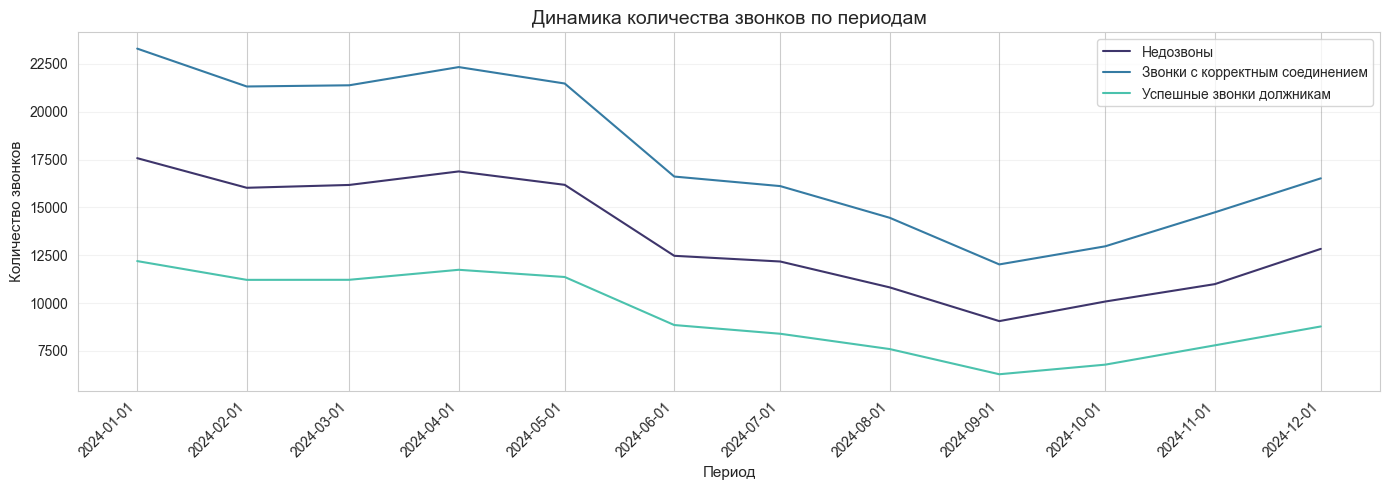

In [11]:
# Создаем график 
plt.figure(figsize=(14, 5)) 

ax = sns.lineplot(
    data=all_calls_df,
    x='period',
    y='count_calls',
    hue='type',       # Разделить линии по этому столбцу    
    dashes=False,
    linewidth=1.5,
    palette='mako'
)

ax.set_title('Динамика количества звонков по периодам', fontsize=14)
ax.set_xlabel('Период', fontsize=11)
ax.set_ylabel('Количество звонков', fontsize=11)
ax.grid(True, axis='y', color='gray', alpha=0.1)
all_periods = all_calls_df['period'].unique()
ax.set_xticks(all_periods)
plt.xticks(rotation=45, ha='right')
ax.legend(title=False)
plt.tight_layout()

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Динамика количества звонков по периодам.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

В первые три квартала наблюдается синхронное и последовательное снижение всех трех показателей: общего числа звонков с соединением, количества успешных звонков и даже недозвонов. Это падение напрямую коррелирует с сокращением числа опытных сотрудников. 

Самая низкая точка на графике в сентябре совпадает с минимальной численностью команды перед началом массового найма.

Увеличение общей численности команды позволило остановить падение и начать восстановление объемов звонков.

## Распределение кол-ва звонков по дням недели

In [12]:
# Добавляем день недели и месяц совершенного звонка
calls['weekday'] = calls['call_date'].dt.day_name()
calls['month'] = calls['call_date'].dt.month_name()

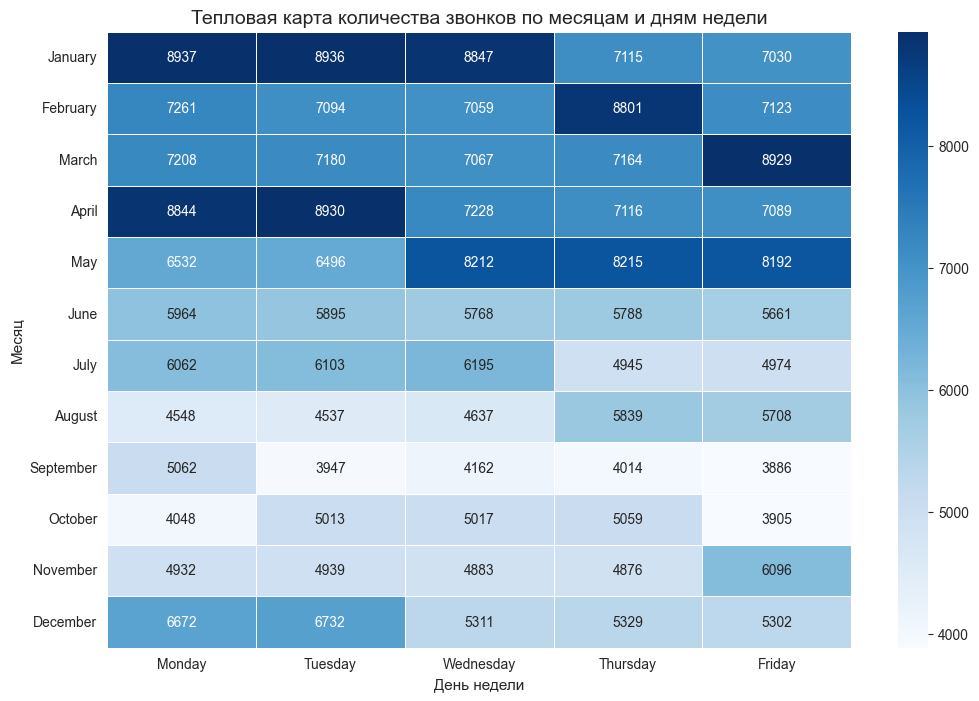

In [13]:
call_counts = calls.groupby(['month', 'weekday']).size().reset_index(name='call_count')

# Создаем сводную таблицу (матрицу)
pivot_table = call_counts.pivot_table(index='month', columns='weekday', values='call_count', fill_value=0)

# Задаем правильный порядок для осей, чтобы было наглядно
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Пересортировываем строки и столбцы в нашей таблице
pivot_table = pivot_table.reindex(index=month_order, columns=day_order)


# Построение тепловой карты 
plt.figure(figsize=(12, 8))

heatmap = sns.heatmap(
    pivot_table,
    annot=True,      # Показываем количество звонков в ячейках
    fmt='g',         # Формат чисел (убирает .0 в конце)
    cmap='Blues',  
    linewidths=.5
)

plt.title('Тепловая карта количества звонков по месяцам и дням недели', fontsize=14)
plt.xlabel('День недели', fontsize=11)
plt.ylabel('Месяц', fontsize=11)
plt.xticks(rotation=0) 
plt.yticks(rotation=0)

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Тепловая карта количества звонков по месяцам и дням недели.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

Самый явный тренд - это значительное падение количества звонков в летние месяцы и продолжающееся снижение в начале осени (сентябрь, октябрь), что неудивительно, т.к. период увольнения сотрудников пришелся на лето.

В ноябре, и особенно в декабре, показатели начинают восстанавливаться. Это не возврат к пиковым значениям начала года, но явная положительная динамика по сравнению с осенним провалом.

Хотя летнее снижение очевидно, самое дно было достигнуто не летом, а в сентябре и октябре. Вторник сентября (3947) и пятница сентября (3886) - это абсолютные минимумы за весь год. 

**Недельная динамика**

В большинстве месяцев неделя начинается очень активно. 
Пятница - самый нестабильный день. Она может быть как одним из самых загруженных дней (как в марте — 8929, самый высокий показатель в месяце), так и одним из самых провальных (как в сентябре - 3886, абсолютный минимум).

В то время как в большинстве месяцев пик приходится на начало недели, в феврале самый активный день - четверг (8801).

Середина недели (среда, четверг) - чаще всего стабильные, но не пиковые дни. Они реже показывают экстремальные значения, за исключением упомянутого февраля.

## Распределение длительности разговора в звонках с корректным соединением

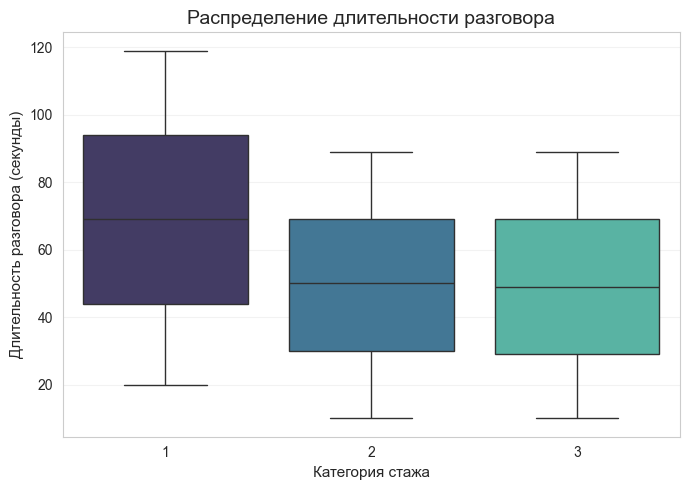

In [14]:
# Распределение длительности разговора в звонках с корректным соединением
plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=successful_calls,
    x='category_of_experience',
    y='talk',
    palette='mako'
    )
ax.set_title('Распределение длительности разговора', fontsize=14)
ax.set_xlabel('Категория стажа', fontsize=11)
ax.set_ylabel('Длительность разговора (секунды)', fontsize=11)

plt.grid(True, axis='y', color='gray', alpha=0.1)
plt.tight_layout()

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Распределение длительности разговора.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

Медиана для новых сотрудников составляет около 70 секунд, что существенно выше, чем у более опытных сотрудников (примерно 50 секунд). Это означает, что в среднем новый сотрудник тратит на один разговор на 40% больше времени. Межквартильный размах и 'усы' у первой категории сотрудников самые широкие. Это говорит о нестабильности.

Также важным выводом является практическая идентичность показателей у сотрудников 2-й категории (стаж 3-6 месяцев) и 3-й категории (стаж более 6 месяцев). Сотрудник выходит на плановые показатели эффективности уже после первых трех месяцев работы.

## Кол-во контактов в час

In [15]:
# Группируем данные и добавляем агрегированные значения
successful_calls_agg = successful_calls.groupby(['name', 'period']).agg(
    count_calls=('talk', 'count'),  # Подсчет количества звонков
    mean_talk=('talk', 'mean'),  # Среднее значение живого разговора
    hours=('hours', 'max'),    # Часы работы
    category_of_experience=('category_of_experience', 'max')  # Категория стажа
).reset_index()

successful_calls_agg['calls_per_hour'] = successful_calls_agg['count_calls']/successful_calls_agg['hours']

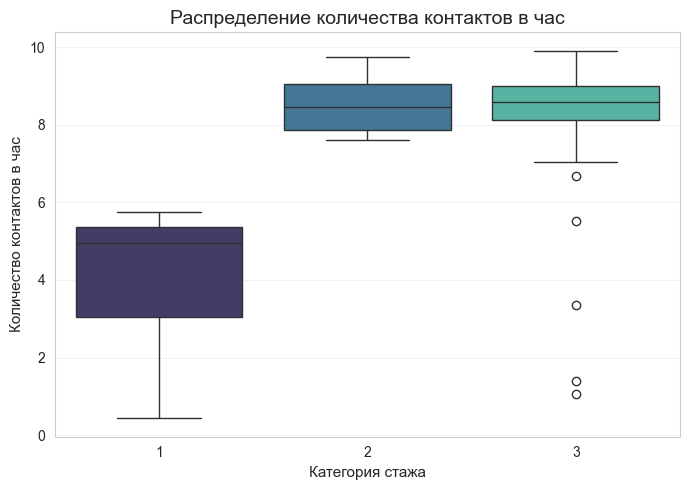

In [16]:
# Кол-во контактов в час
plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=successful_calls_agg,
    x='category_of_experience',
    y='calls_per_hour',
    palette='mako'
    )
ax.set_title('Распределение количества контактов в час', fontsize=14)
ax.set_xlabel('Категория стажа', fontsize=11)
ax.set_ylabel('Количество контактов в час', fontsize=11)

plt.grid(True, axis='y', color='gray', alpha=0.1)
plt.tight_layout()

# Сохраняем график в папку images
file_path = os.path.join(IMAGE_DIR, 'Распределение количества контактов в час.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

1. Категория 1 (Новые сотрудники):
Средняя производительность - около 5 контактов в час.
Основная масса новых сотрудников (50% из них) делает от 3 до 5.5 контактов в час. 
Производительность колеблется от почти нуля до ~5.8 контактов/час.
2. Категория 2 (Сотрудники с опытом от 3 до 6 месяцев):
Средняя производительность - около 8.5 контактов в час. Это огромный скачок по сравнению с новыми сотрудниками.
Ящик очень узкий, от 8 до 9. Это значит, что сотрудники этой группы очень стабильны, их производительность практически не колеблется. 
Весь диапазон их производительности очень узкий (от ~7.5 до ~9.8).
3. Категория 3 (Опытные сотрудники со стажем больше 6 месяцев):
Средняя производительность - тоже около 8.5-9 контактов в час, как и у категории 2. 
Ящик тоже узкий, что говорит о высокой эффективности основной массы этих сотрудников.
У этой категории есть несколько выбросов - это те сотрудники, которые уволились в начале или середине месяца.

Самый важный вывод - один ушедший опытный сотрудник (8.5 контактов/час) по производительности равен почти двум нанятым новичкам (5 контактов/час). Это полностью объясняет, почему при восстановлении численности команды в конце года общие показатели не вернулись к прежним значениям.

In [17]:
# Посмотрим на выбросы в категории 3 (опытные сотрудники)
experienced_worst_employees = (successful_calls_agg.
                               loc[successful_calls_agg['category_of_experience'] == 3].
                               sort_values('calls_per_hour').head(5)['name'])
employee.loc[employee['name'].isin(experienced_worst_employees)].groupby('name')['dismissal_date'].max()

name
Артём Волков           2024-10-23
Виктория Виноградова   2024-07-20
Мария Новикова         2024-09-13
Михаил Павлов          2024-07-04
Полина Соловьёва       2024-09-05
Name: dismissal_date, dtype: datetime64[ns]

Рассчитаем конверсию в звонок с корректным соединением

In [18]:
conversion = pd.merge(calls.groupby('period').agg(count_calls_total=('uuid', 'count')).reset_index(),
                      successful_calls.groupby('period').agg(count_calls_successful=('uuid', 'count')).reset_index(),
                      how='inner', on='period')
conversion['conversion'] = round(conversion['count_calls_successful']/conversion['count_calls_total']*100, 2)
print('Конверсия в среднем в месяц составляет {}%'.format(conversion['conversion'].median()))

Конверсия в среднем в месяц составляет 57.015%


# Выводы

1. Анализ показал, что падение объемов контактов в летне-осенний период было вызвано не просто сокращением штата, а массовым уходом опытных сотрудников (стаж более 6 месяцев). Несмотря на восстановление общей численности к концу года до 16 человек (по сравнению с 17 в январе), команда на 50% стала состоять из новичков. Это привело к тому, что общие показатели не вернулись к пиковым значениям начала года.
2. Существует критическая разница в эффективности между новыми и опытными сотрудниками:
- Новичок (стаж меньше 3 месяцев) совершает в среднем 5 контактов в час. Его работа нестабильна, а среднее время разговора на 40% дольше, чем у опытного коллеги.
- Опытный сотрудник (стаж больше 3 месяцев) совершает в среднем 9 контактов в час.
Таким образом, по производительности один опытный сотрудник эквивалентен 2 новым сотрудникам. Этот факт является ключевым для планирования найма.
3. Ключевой период адаптации составляет 3 месяца.
Анализ показывает, что сотрудники со стажем от 3 до 6 месяцев по своей эффективности практически не уступают коллегам со стажем более полугода. Это означает, что через 3 месяца обучения и практики сотрудник выходит на плановую производительность. Этот срок необходимо закладывать в планы по масштабированию.